<a href="https://colab.research.google.com/github/daniel-usp/risco/blob/main/EWMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [172]:
!pip install yfinance

In [174]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf


#Inserir os tickers conforme o Yahoo Finance
TickerA='PETR4.SA'
TickerB='CIEL3.SA'
TickerC = 'VIIA3.SA'
TickerD = 'COGN3.SA'
TickerE = 'VALE3.SA'

prices=pd.DataFrame()
tickers = [TickerA, TickerB, TickerC, TickerD,TickerE] #Não se deve esquecer de completar a lista 
for t in tickers:
  data = yf.Ticker(t)
  prices[t]= data.history(period="3y")['Close'].dropna()
janela_teste = 100 #Padrão de 100 dias
prices_train = prices.iloc[:-janela_teste,:]
prices_test = prices.iloc[-janela_teste:,:]



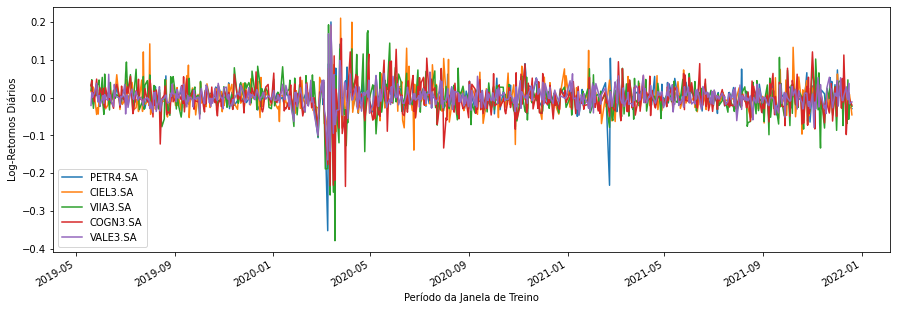

In [175]:
log_returns=np.log(prices_train).diff()
log_returns.plot(figsize=(15,5))
plt.ylabel('Log-Retornos Diários')
plt.xlabel('Período da Janela de Treino')
plt.show()

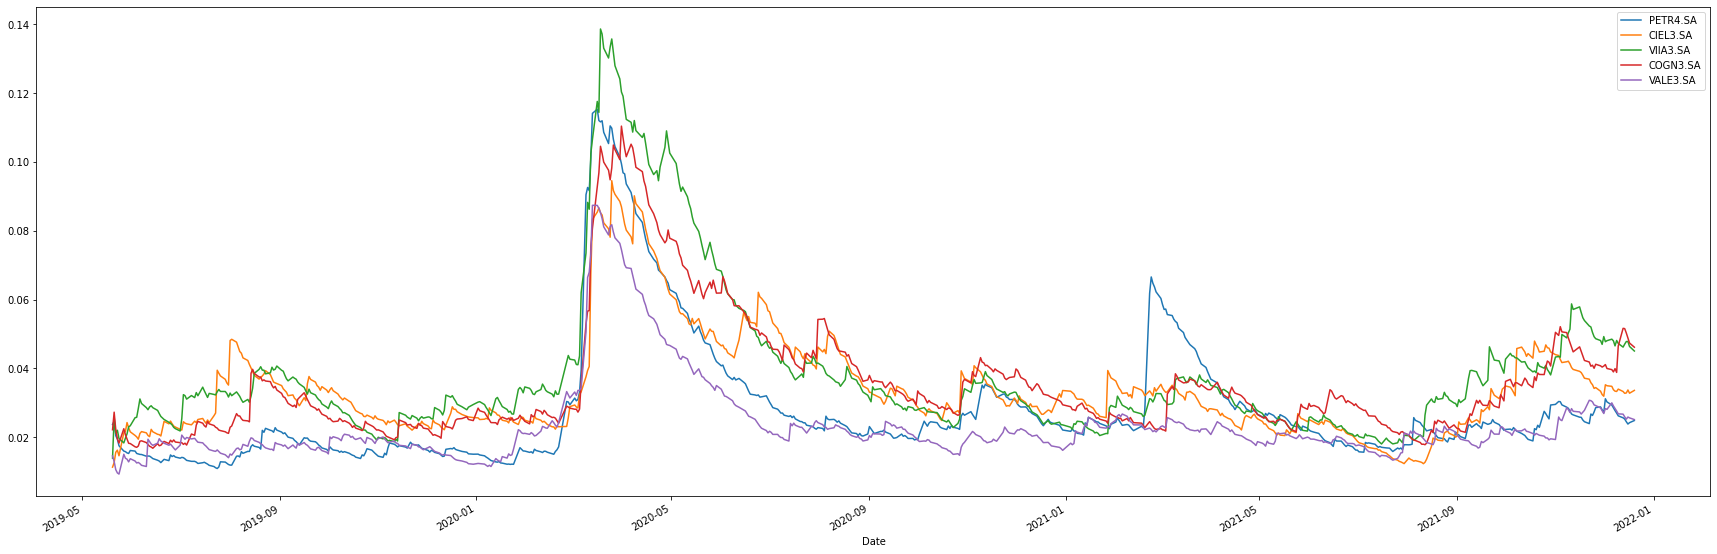

In [176]:

log_returns.fillna(0, inplace = True)
vol_EWMA = (log_returns.ewm(alpha = 0.06, adjust = False).std())
vol_EWMA.plot(figsize = (30,10))




In [177]:
np.random.seed(1)
nticks = len(tickers)
nsample=10000
pfolio_returns = []
pfolio_volatilities = []
all_weights = np.zeros((nsample, nticks))
exp_return = np.zeros(nsample)
exp_std = np.zeros(nsample)
exp_var = np.zeros(nsample)
Sharpe = np.zeros((nsample,1))
for i in range(nsample):
    weights = np.random.random(nticks)
    weights = weights/np.sum(weights)
    
    all_weights[i,:] = weights #salva os pesos
    
    exp_return[i]= np.sum(weights*log_returns.mean())*250 
    exp_var[i] = np.dot(weights.T,np.dot(log_returns.cov()*250, weights))
    exp_std[i] = np.sqrt(exp_var[i]) #Risco
    
    Sharpe[i,:]=exp_return[i]/exp_std[i] #Retorno/Risco
    
    pfolio_returns.append(exp_return[i])
    pfolio_volatilities.append(exp_std[i])
    
pfolio_returns=np.array(pfolio_returns)
pfolio_volatilities=np.array(pfolio_volatilities)

#EWMA da Carteira

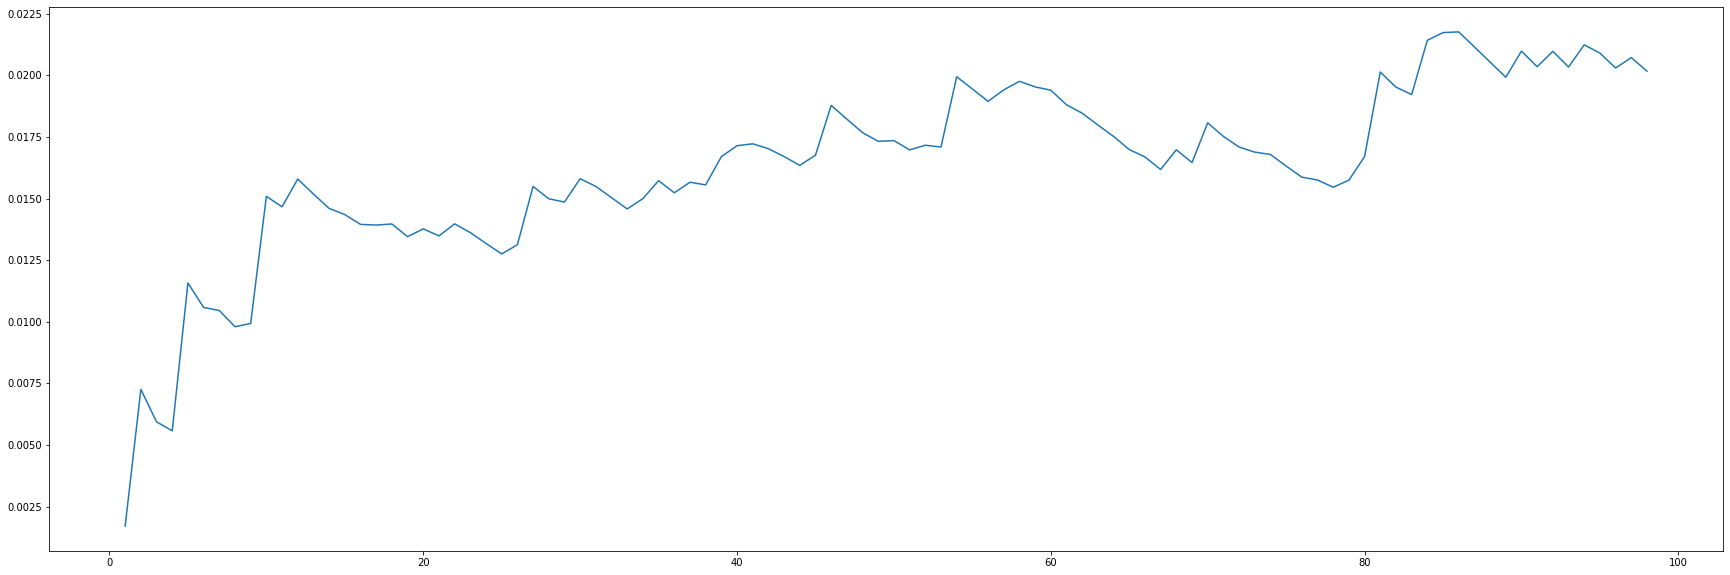

In [178]:
import numpy as np
min = exp_std.min()
item = np.where(exp_std == min)
optimal_weights = all_weights[item]
col = pd.DataFrame(tickers[:])
weights_vol = pd.DataFrame(optimal_weights.T)
vol = pd.concat([col,weights_vol], axis =1)
vol.columns = ['tickers', 'weights']

#Matriz de pesos de risco mínimo para a amostra teste
iter = 0 
weights_total = []
while iter < 100:
  weights_total.append([list(vol['weights'])][0])
  iter += 1
weights_total = pd.DataFrame(weights_total)
weights_total.columns = tickers
weights_total = weights_total.iloc[1:,:]
weights_total

log_returns_test=np.log(prices_test).diff()
log_returns_test.dropna(inplace = True)
linha = len(log_returns_test)
col = len(tickers)

carteira = []
for i in range(len(log_returns_test)):
  for j in range(len(tickers)):
    carteira.append(list(log_returns_test.iloc[i])[j]*list(weights_total.iloc[i])[j])
carteira = pd.DataFrame(np.array(carteira).reshape(99,5))
carteira['ret_port'] = carteira.sum(axis=1)

vol_EWMA = (carteira['ret_port'].ewm(alpha = 0.06, adjust = False).std())
vol_EWMA.plot(figsize = (30,10))



In [179]:
data = yf.Ticker('BOVA11.SA')
ibov = data.history(period="3y")['Close'].dropna()
janela_teste = 100 #Padrão de 100 dias
ibov = pd.DataFrame(ibov)
janela_teste = 100 #Padrão de 100 dias
ibov_test = ibov.iloc[-janela_teste:,:]
ibov_test

,Close
Date,
2021-12-21,101.419998
2021-12-22,101.430000
2021-12-23,100.849998
2021-12-27,101.599998
2021-12-28,101.059998
...,...
2022-05-11,100.639999
2022-05-12,102.040001
2022-05-13,103.290001


#EWMA do IBOV

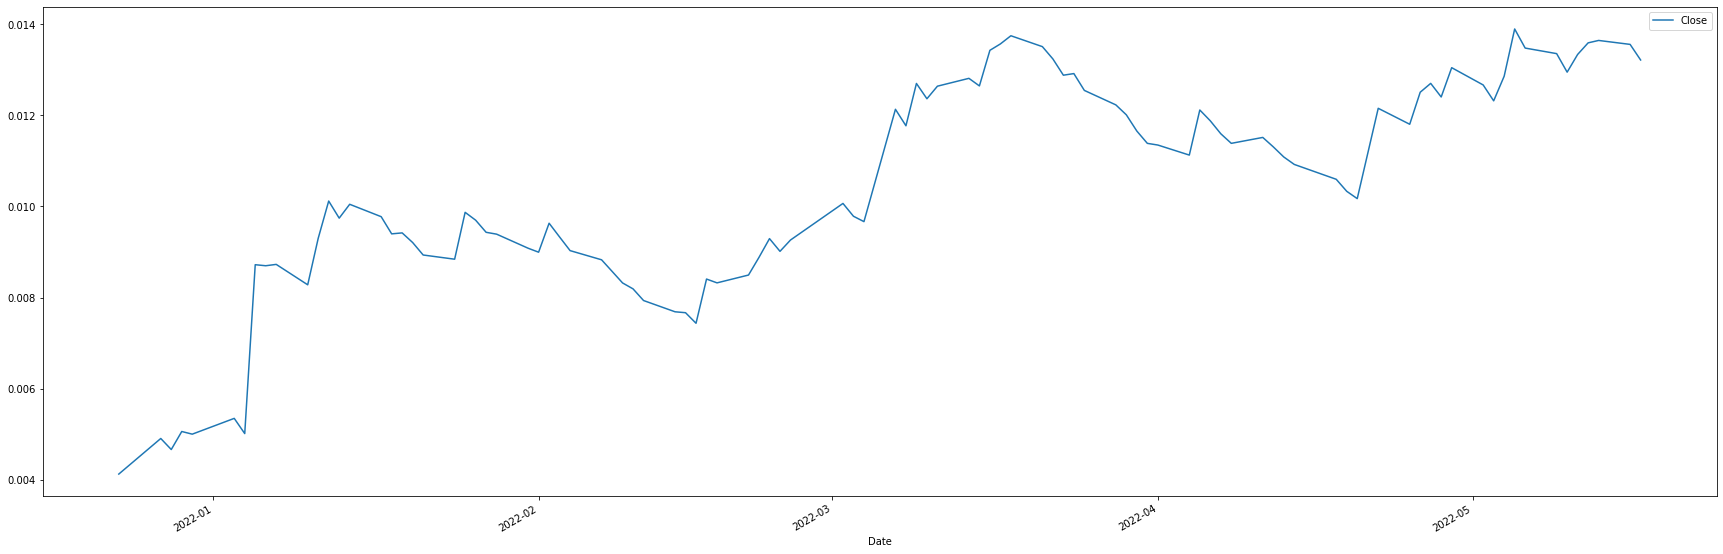

In [180]:
ret_ibov=np.log(ibov_test).diff()
ret_ibov.dropna(inplace = True)
vol_ibov = (ret_ibov.ewm(alpha = 0.06, adjust = False).std())
vol_ibov.plot(figsize = (30,10))

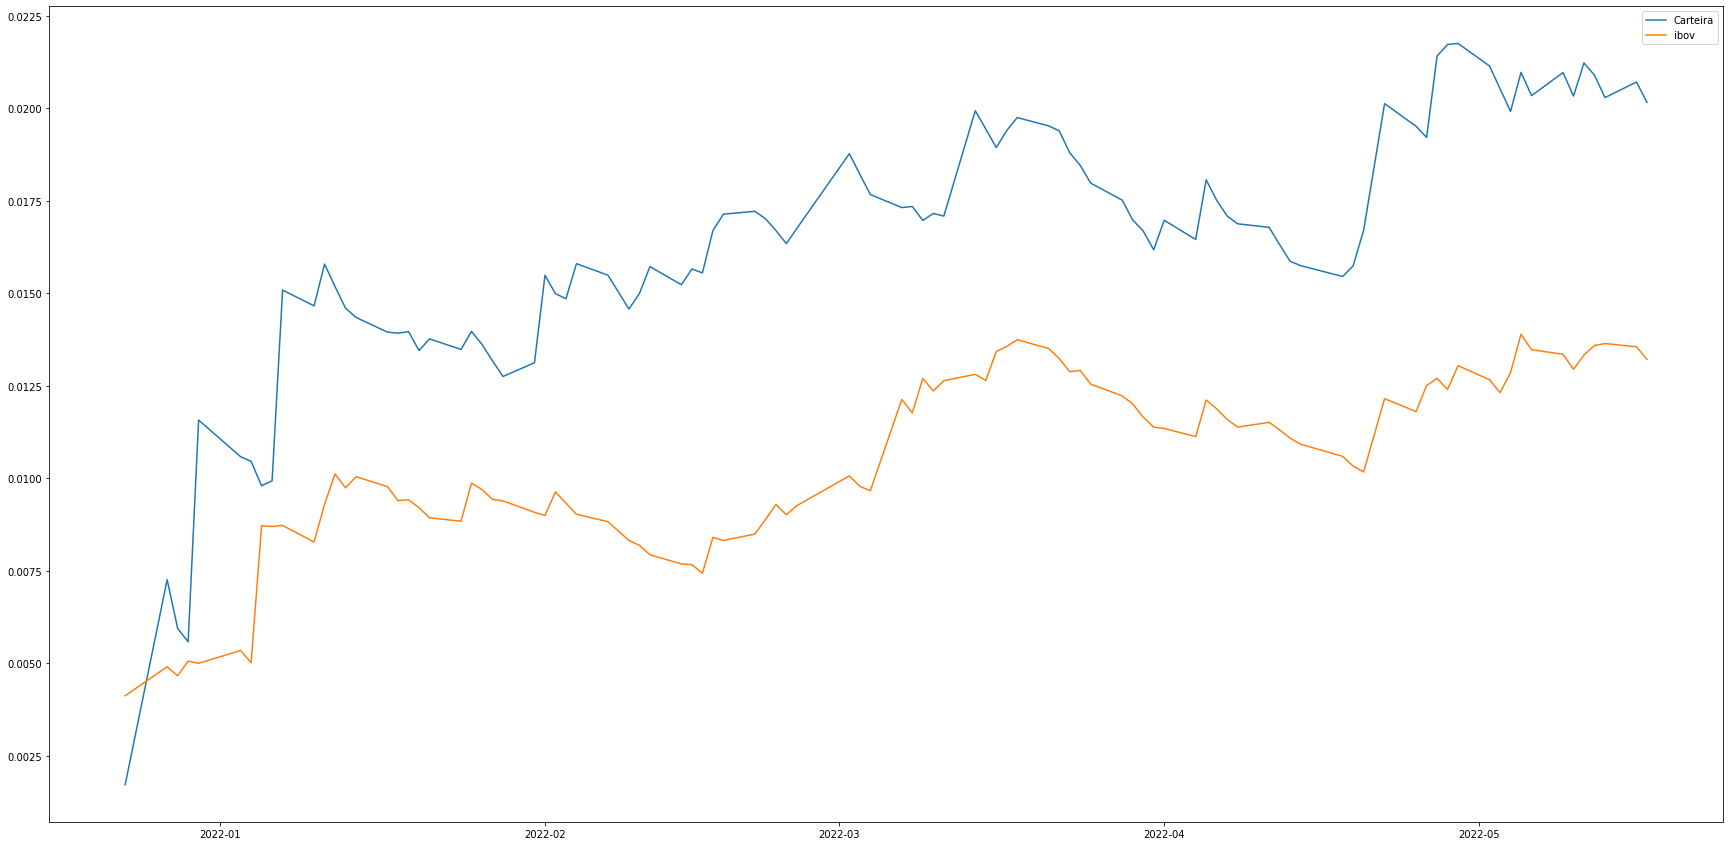

In [184]:
vol_ibov = pd.DataFrame(vol_ibov).dropna()
vol_ibov.columns = ['vol_ibov']
vol_EWMA = pd.DataFrame(vol_EWMA).dropna()
vol_EWMA.columns = ['vol_EWMA']
vol_EWMA = vol_EWMA.set_index(vol_ibov.index)

import numpy as np
import matplotlib.pyplot as plt 
plt.plot(vol_EWMA)
plt.plot(vol_ibov)
plt.legend(['Carteira','ibov'])
plt.rcParams["figure.figsize"] = (30,10)
